## Processamentos

### Pedro Henrique Arruda Faustini

Este trabalho procura reconhecer rostos de pessoas. Para tanto, existe um conjunto de faces, e por meio de aprendizado supervisionado, treina-se modelos que se familiarizem com elas. Então, fornce-se aos modelos faces ainda não vistas por ele para que eles digam quem é quem.

Ao final, uma comparação entre os diferentes algoritmos de classificação é apresentada.

O código encontra-se nos arquivos .py dentro da pasta **face\_detector/**. 

**face\_detector/preprocessor.py** realiza operações de mais baixo nível, como ler imagens e identificar faces.

**face\_detector/person.py** contém a classe com os atributos que representam uma pessoa.

**face\_detector/utils.py** é uma classe com métodos diversos, como exibir uma imagem. Para acelerar o processamento, também contém os caminhos de todas as imagens em formato *hard coded*.

**face\_detector/model.py** é responsável por identificar quem é quem nas imagens.

Dentro da pasta *faces* há 26 pastas identificadas de A a X, uma para cada uma das 26 pessoas que compõem a base de dados. Dentro de cada uma dessas 26 pastas há imagens dessas pessoas.


#### Bibliotecas e versões

* opencv-python==3.4.2

* numpy==1.15.1

* matplotlib==2.2.3

* scikit-learn==0.19.2



In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from face_detector.preprocessor import Preprocessor
from face_detector.model import Model
from face_detector.utils import Utils

In [2]:
def imshow(img, colour=False):
    plt.axis('off')
    if colour == False:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #  OpenCV armazena em BGR, nao RGB
    plt.show()

In [3]:
p = Preprocessor()
u = Utils()
m = Model()

### Identificação dos rostos

Primeiro as imagens são carregadas. Nelas, as pessoas estão em meio a um contexto, então é necessário identificar seu rosto e cortá-lo. Abaixo é mostrado um exemplo disso.

As imagens originalmente são coloridas. Contudo, ao serem carregadas, são convertidas para escala de cinza.

In [4]:
imgs = p.load_images() 

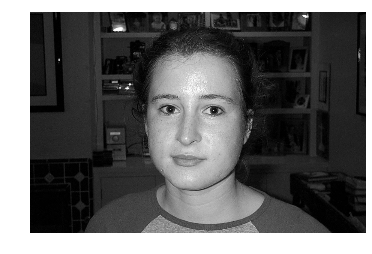

In [5]:
u.imshow(imgs[120][0])

O método *get_face* da classe *preprocessor* (linha 59) retorna um objeto *Person* que armazena informações de uma imagem. Entre essas informações está a imagem cortada de apenas a face de uma pessoa. 

A identificação do rosto ocorre com o auxílio dos arquivos *cascade* na pasta cascades. A partir das coordenadas do rosto, o método *_crop_image* na linha 16 retorna a imagem recortada, com somente o rosto da pessoa.

Ainda que possa distorcer um pouco as imagens, os rostos são reescalados na linha 93 para terem todos o mesmo tamanho (512x512 pixels). Além disso, o histograma de cada imagem é equalizado (também linha 93). Isso se mostrou eficiente, pois imagens com diferentes brilhos introduziam ruídos indesejados na classificação.

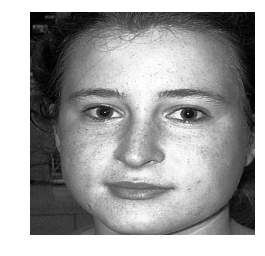

In [6]:
person = p.get_face(img=imgs[120][0], label=imgs[120][1])
u.imshow(person.face_resized)

### Classificação

Para a classificação, o procedimento acima é realizado para todas as imagens da base de dados. É criada uma lista de tuplas chamada *data*. Cada tupla contém (i) imagem do rosto de uma pessoa e (ii) a classe a que aquela imagem pertence. Cada pessoa diferente pertence a uma classe.

As imagens são então fornecidas a um modelo, que procura aprender as características de cada rosto. O modelo usa 70% da base para treinamento. Ele não tem acesso aos 30% restantes, que são usados como conjunto de teste, e deve classificar esses rostos conforme aquilo que aprendeu durante a etapa de treinamento.

Os experimentos conduzidos avaliam o desempenho de três algoritmos de classificação: SVM, Naive Bayes e LDA. As métricas levadas em consideração foram a *precisão*, *revocação* e *f1-score*.

* Precisão:

    Intuitivamente, pode ser vista como a seguinte pergunta: de todas as vezes que o classificador disse que tais objetos eram da classe X, quantas vezes ele acertou?
    
    Formalmente, para um problema multiclasse, a precisão é calculada pela soma dos valores da diagonal principal de uma matriz de confusão (sendo a diagonal principal os acertos, ou *true positives*), dividindo-se pelo total de predições para aquela classe, sejam elas certas (*true positives*) ou erradas (*false positives*).
    
    \begin{equation*}
    Precisao = \frac{TP}{TP + FP}
    \end{equation*}

* Revocação:

    Intuitivamente, pode ser vista como a seguinte pergunta: se uma classe X tem *n* objetos, quantos desses *n* objetos foram identificados pelo classificador?
    
    Formalmente, para um problema multiclasse, a revocação é calculada pela soma dos valores da diagonal principal de uma matriz de confusão (sendo a diagonal principal os acertos), dividindo-se pelo total de instâncias daquela classe na base de dados (*true positives* e *false negatives*).
    
    \begin{equation*}
    Revocacao = \frac{TP}{TP + FN}
    \end{equation*}

* F1-Score:

    Intuitivamente, representa um *tradeoff* entre as precisão e revocação. 
    
    Formalmente, é a média harmônica entre precisão e revocação.
    
    \begin{equation*}
    F1score = 2 * \frac{precisao\ *\ revocacao}{precisao + revocacao}
    \end{equation*}
    

A célula seguinte executa os experimentos. São 26 pessoas (ou 26 classes) na base de dados, sendo cada uma identificada por uma letra do alfabeto. A tabela abaixo apresenta os resultados de precisão, revocação e f1-score para cada uma das classes em todos os algoritmos usados.

Cada um dos algoritmos foi treinado com as mesmas imagens, usando os mesmos atributos. Para gerar os atributos, a imagem equalizada de cada face (que é uma matriz 512x512) foi passada para um algoritmo PCA, que é um algoritmo de redução de dimensionalidade.

Em resumo, o que o PCA faz é diminuir os atributos para um determinado número de componentes (no caso deste trabalho, 100 componentes). Ele faz isso convertendo um conjunto de variáveis possivelmente correlacionadas (e portanto redundantes) num conjunto linearmente independente. No caso deste trabalho, se a imagem inteira da face de cada pessoa fosse enviada para treinamento, os modelos seriam treinados com 262.144 atributos, o que além de ser custoso pode incluir muitas partes do rosto das pessoas que pouco contribuem para distinguir quem é quem. Com o PCA configurado para 100 componentes, ele reduzirá o número de atributos para 100.

### Experimentos

In [7]:
data = []
for img in imgs:
    person = p.get_face(img=img[0], label=img[1])
    if person is not None:
        data.append((person.face_resized, person.label))
        

A classe Model contém o método *classify*, responsável pela classificação das imagens do conjunto de teste. Este método recebe como entrada uma lista de tuplas, em que cada tupla contém uma imagem de um rosto e uma string com a classe associada àquela imagem.

Entre as linhas 20 e 27 ela realiza o corte na base, em que 70% das imagens são usadas para treinamento e 30% para teste. A extração dos atributos acontece a partir da linha 29. A partir da linha 34 ocorre treinamento e teste dos classificadores.

In [8]:
m.classify(data=data)

SVM: 
             precision    recall  f1-score   support

          A       1.00      0.90      0.95        10
          B       1.00      1.00      1.00         9
          C       1.00      1.00      1.00         1
          D       1.00      1.00      1.00         8
          E       1.00      1.00      1.00        10
          F       0.75      1.00      0.86         6
          G       1.00      1.00      1.00         5
          H       0.75      1.00      0.86         6
          I       0.00      0.00      0.00         2
          J       0.00      0.00      0.00         0
          K       0.86      1.00      0.92         6
          L       0.86      1.00      0.92         6
          M       0.88      1.00      0.93         7
          N       0.00      0.00      0.00         1
          O       0.50      1.00      0.67         2
          P       0.00      0.00      0.00         1
          Q       1.00      1.00      1.00         4
          R       1.00      1.00      1

Os resultados em geral se mostram bons. Em especial o Linear Discriminant Analysis, que obtém resultados de precisão e revocação quase perfeitos.